In [1]:
import numpy as np
import pydicom
import nibabel as nib
import os
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from shapely.geometry import Polygon
from rasterio.features import rasterize
import pandas as pd
from scipy import ndimage
from scipy.ndimage.measurements import label
from scipy.spatial import ConvexHull
import statistics
import math
import cmath

In [193]:
def readDcmPet(pathToDcmFolder):

    times=[]
    locs=[]
    for i in range(len(os.listdir(pathToDcmFolder))):
        file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
        ds=pydicom.dcmread(file)
        times.append(ds.AcquisitionTime)
        locs.append(ds.SliceLocation)
    uniTimes=np.sort(np.unique(np.array(times)))
    uniLocs=np.sort(np.unique(np.array(locs)))
    img4d=np.zeros((220,220,380,24))
    for k in range(24):
        for i in range(len(os.listdir(pathToDcmFolder))):
            if times[i]==uniTimes[k]:
                file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
                ds=pydicom.dcmread(file)
                for j in range(len(uniLocs)):
                    if uniLocs[j]==locs[i]:
                        img4d[:,:,j,k]=cv2.resize(ds.pixel_array*ds[0x0028, 0x1053].value,(220,220))+ds[0x0028, 0x1052].value
    return(img4d)

def readDcmCt(ctfilepath):

    ctlocs=[]
    for i in range(len(os.listdir(ctfilepath))):
        file='{}/{}'.format(ctfilepath,os.listdir(ctfilepath)[i])
        if file[-4:]=='.dcm':
            ds=pydicom.dcmread(file)
            ctlocs.append(ds.SliceLocation)
    ctUniLocs=np.sort(np.unique(np.array(ctlocs)))
    ctImg=np.zeros((512,512,380))
    for i in range(len(os.listdir(ctfilepath))):
        file='{}/{}'.format(ctfilepath,os.listdir(ctfilepath)[i])
        if file[-4:]=='.dcm':
            ds=pydicom.dcmread(file)
            for j in range(len(ctUniLocs)):
                if ctUniLocs[j]==ctlocs[i]:
                    ctImg[:,:,j]=ds.pixel_array
    ctImg1=np.zeros((220,220,380))
    for i in range(380):
        ctImg1[:,:,i]=cv2.resize(ctImg[70:442,70:442,i],(220,220))
    return(ctImg1)

def processDoctorsMask(mask):
    
    mask1=np.zeros((220,220,380))
    for i in range(380):
        mask1[:,:,i]=mask[:,:,379-i]
    return(mask1)

def preprocessTotalSegImg(img_path):

    img=nib.load(img_path)
    img=img.get_fdata()
    img1=np.zeros((220,220,380))
    for i in range(380):
        img_i=cv2.resize(img[70:442,70:442,379-i],(220,220))
        for j in range(220):
            img1[:,j,i]=img_i[j,:]
    img1=cv2.flip(img1,0)
    img1=np.round(img1,1)
    return(img1)

def totalSegImgForASingleKidney(img,side):

    if side=='left':
        j=38
    if side=='right':
        j=39
    img1=np.array(img==j,dtype=int)
    return(img1)

def greatestConnectedComponentOnly(img):

    #create another image matrix where the values within the greatest connected component are 1 and the others are 0
    if len(img.shape)==3:
        structure=np.ones((3,3,3),dtype=int)
    if len(img.shape)==2:
        structure=np.ones((3,3),dtype=int)
    labeled, ncomponents = label(img,structure)
    u1=[]
    for u in range(1,ncomponents+1):
        img0=np.array(labeled==u,dtype=int)
        u1.append(np.sum(img0))
    u=np.argmax(u1)+1
    img1=np.array(labeled==u,dtype=int)
    return(img1)

def findBoundingBox(img):

    img1=greatestConnectedComponentOnly(img)
    k5=0
    while(np.max(img1[:,:,k5])==0):
        k5+=1
    k6=k5
    while((np.max(img1[:,:,k6])>0) & (k6<379)):
        k6+=1
    k3=0
    while(np.max(img1[:,k3,k5:k6])==0):
        k3+=1
    k4=k3
    while((np.max(img1[:,k4,k5:k6])>0) & (k4<219)):
        k4+=1
    k1=0
    while(np.max(img1[k1,k3:k4,k5:k6])==0):
        k1+=1
    k2=k1
    while((np.max(img1[k2,k3:k4,k5:k6])>0) & (k2<219)):
        k2+=1
    return(k1,k2,k3,k4,k5,k6)

def findIniArr(img4d,k1,k2,k3,k4,k5,k6):

    imgArr=img4d[k1:k2,k3:k4,k5:k6,:]
    imgArr1=np.mean(imgArr,axis=3)
    iniArr=np.array(imgArr1>np.quantile(imgArr1,0.81),dtype=int)
    structure=np.ones((3,3),dtype=int)
    for i in range(iniArr.shape[2]):
        labeled, ncomponents = label(iniArr[:,:,i]==0,structure)
        for u in range(1,ncomponents+1):
            img0=np.array(labeled==u,dtype=int)
            if np.max(img0[0,:])==0 and np.max(img0[img0.shape[0]-1,:])==0 and np.max(img0[:,0])==0 and np.max(img0[:,img0.shape[1]-1])==0:
                iniArr[:,:,i]+=img0
    iniArr=greatestConnectedComponentOnly(iniArr)
    return(iniArr)

def weightedMean(point,arr):

    i=int(np.floor(point[0]))
    j=int(np.floor(point[1]))
    k=int(np.floor(point[2]))
    i1=point[0]-i
    j1=point[1]-j
    k1=point[2]-k
    v=(1-i1)*(1-j1)*(1-k1)*arr[i,j,k]+i1*(1-j1)*(1-k1)*arr[i+1,j,k]+(1-i1)*j1*(1-k1)*arr[i,j+1,k]+(1-i1)*(1-j1)*k1*arr[i,j,k+1]+i1*j1*(1-k1)*arr[i+1,j+1,k]+i1*(1-j1)*k1*arr[i+1,j,k+1]+(1-i1)*j1*k1*arr[i,j+1,k+1]+i1*j1*k1*arr[i+1,j+1,k+1]
    return(v) 

def pointFromPolarCoordinates(h,theta,phi):

    return(h*np.array((math.sin(theta)*math.cos(phi)/1.65,math.sin(theta)*math.sin(phi)/1.65,math.cos(theta)/3)))

def distanceBetweenTwoPoints(x,y):

    return(((1.65*(x-y)[0])**2+(1.65*(x-y)[1])**2+(3*(x-y)[2])**2)**0.5)

def imageFromThreeCoordinates(s1,s2,s3,arr,method):

    u=s2-s1
    v=s3-s1
    len_u=distanceBetweenTwoPoints(s1,s2)
    len_v=distanceBetweenTwoPoints(s1,s3)
    img1=np.zeros((round(len_u),round(len_v)))
    for i in range(round(len_u)):
        for j in range(round(len_v)):
            point=s1+i/round(len_u)*u+j/round(len_v)*v
            if 0<point[0]<(arr.shape[0]-1) and 0<point[1]<(arr.shape[1]-1) and 0<point[2]<(arr.shape[2]-1):
                if method=='mean':
                    img1[i,j]=weightedMean(point,arr)
                if method=='round':
                    img1[i,j]=arr[round(point[0]),round(point[1]),round(point[2])]
    return(img1)

def findProjectedPoint(point,s1,s2,s3):

    u=s2-s1
    v=s3-s1
    len_u=distanceBetweenTwoPoints(s1,s2)
    len_v=distanceBetweenTwoPoints(s1,s3)
    t=(u[0]*(point-s1)[1]-u[1]*(point-s1)[0])/(u[0]*v[1]-u[1]*v[0])
    s=((point-s1)[0]-t*v[0])/u[0]
    projectedPoint=np.array((s*len_u,t*len_v))
    return(projectedPoint)

def findPointIn3d(point,s1,s2,s3):

    len_u=distanceBetweenTwoPoints(s1,s2)
    len_v=distanceBetweenTwoPoints(s1,s3)
    pointIn3d=s1+point[0]/len_u*(s2-s1)+point[1]/len_v*(s3-s1)
    return(pointIn3d)

def findTheAxis(arr,com):

    h=np.max(arr.shape*np.array((1.65,1.65,3)))
    thetaPhiArr=np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            theta=i/10*math.pi/2
            phi=j/10*2*math.pi
            s1=com+pointFromPolarCoordinates(h,math.pi/2,phi+math.pi/2)
            s2=com+pointFromPolarCoordinates(h,math.pi/2-theta,phi+math.pi)
            s3=com+pointFromPolarCoordinates(h,math.pi/2+theta,phi)
            img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
            thetaPhiArr[i,j]=np.sum(img1)
    i0,j0=np.unravel_index(np.argmin(thetaPhiArr,axis=None),thetaPhiArr.shape)
    theta0=i0/10*math.pi/2
    phi0=j0/10*2*math.pi
    for i in range(10):
        for j in range(10):
            theta=theta0+(i-4.5)/100*math.pi/2
            phi=phi0+(j-4.5)/100*2*math.pi
            s1=com+pointFromPolarCoordinates(h,math.pi/2,phi+math.pi/2)
            s2=com+pointFromPolarCoordinates(h,math.pi/2-theta,phi+math.pi)
            s3=com+pointFromPolarCoordinates(h,math.pi/2+theta,phi)
            img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
            thetaPhiArr[i,j]=np.sum(img1)
    i1,j1=np.unravel_index(np.argmin(thetaPhiArr,axis=None),thetaPhiArr.shape)
    theta1=theta0+(i1-4.5)/100*math.pi/2
    phi1=phi0+(j1-4.5)/100*2*math.pi
    for i in range(10):
        for j in range(10):
            theta=theta1+(i-4.5)/1000*math.pi/2
            phi=phi1+(j-4.5)/1000*2*math.pi
            s1=com+pointFromPolarCoordinates(h,math.pi/2,phi+math.pi/2)
            s2=com+pointFromPolarCoordinates(h,math.pi/2-theta,phi+math.pi)
            s3=com+pointFromPolarCoordinates(h,math.pi/2+theta,phi)
            img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
            thetaPhiArr[i,j]=np.sum(img1)
    i,j=np.unravel_index(np.argmin(thetaPhiArr,axis=None),thetaPhiArr.shape)
    theta=theta1+(i-4.5)/1000*math.pi/2
    phi=phi1+(j-4.5)/1000*2*math.pi
    x1=com-h*np.array((math.sin(theta)*math.cos(phi)/1.65,math.sin(theta)*math.sin(phi)/1.65,math.cos(theta)/3))
    linesegment=np.zeros((1000))
    for i in range(1000):
        point=com+i/1000*(x1-com)
        if 0<point[0]<(arr.shape[0]-1) and 0<point[1]<(arr.shape[1]-1) and 0<point[2]<(arr.shape[2]-1):
            linesegment[i]=weightedMean(point,arr)
    i=max(np.array(range(1000))[linesegment>0.5])
    l0=com+i/1000*(x1-com)
    y1=com+h*np.array((math.sin(theta)*math.cos(phi)/1.65,math.sin(theta)*math.sin(phi)/1.65,math.cos(theta)/3))
    linesegment=np.zeros((1000))
    for i in range(1000):
        point=com+i/1000*(y1-com)
        if 0<point[0]<(arr.shape[0]-1) and 0<point[1]<(arr.shape[1]-1) and 0<point[2]<(arr.shape[2]-1):
            linesegment[i]=weightedMean(point,arr)
    i=max(np.array(range(1000))[linesegment>0.5])
    l1=com+i/1000*(y1-com)
    if l1[2]<l0[2]:
        u=l1
        l1=l0
        l0=u
    return(l0,l1,theta,phi)

def getTheVertices(bool_img):
    
    vertices = []
    bool_img1=np.pad(bool_img, [(1,1), (1,1)], 'constant')
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        if min(bool_img1[i,j+1],bool_img1[i+2,j+1],bool_img1[i+1,j],bool_img1[i+1,j+2])==0:
            if min(max(bool_img1[i,j+1],bool_img1[i+1,j]),max(bool_img1[i+1,j],bool_img1[i+2,j+1]),
                      max(bool_img1[i+2,j+1],bool_img1[i+1,j+2]),max(bool_img1[i+1,j+2],bool_img1[i,j+1]))==0:
                vertices.append(np.array([i,j]))
    return(vertices)

def findTheNonConvexDirection(arr,com,l0,l1,theta,phi):

    h=np.max(arr.shape*np.array((1.65,1.65,3)))
    nonConvexAreas=[]
    for i in range(100):
        mu=i/100*2*math.pi
        theta1=math.pi/2-theta+abs(math.pi-mu)/math.pi*2*theta
        phi1=phi+mu
        point=com+pointFromPolarCoordinates(h,theta1,phi1)
        s1=point-com+l0
        s2=l0
        s3=l1+(s1-l0)
        img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
        vertices=getTheVertices(img1)
        vertices=np.array(vertices)
        hull=ConvexHull(vertices)
        poly=Polygon(vertices[hull.vertices,:][:,[1,0]])
        hullImg=rasterize([poly],out_shape=(img1.shape))
        nonConvexImg=np.maximum(hullImg-img1,np.zeros((img1.shape)))
        nonConvexImg=greatestConnectedComponentOnly(nonConvexImg)
        nonConvexAreas.append(np.sum(nonConvexImg))
    mu0=np.argmax(nonConvexAreas)/100*2*math.pi
    nonConvexAreas=[]
    for i in range(100):
        mu=mu0+(i-50)/10000*2*math.pi
        theta1=math.pi/2-theta+abs(math.pi-mu)/math.pi*2*theta
        phi1=phi+mu
        point=com+pointFromPolarCoordinates(h,theta1,phi1)
        s1=point-com+l0
        s2=l0
        s3=l1+(s1-l0)
        img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
        vertices=getTheVertices(img1)
        vertices=np.array(vertices)
        hull=ConvexHull(vertices)
        poly=Polygon(vertices[hull.vertices,:][:,[1,0]])
        hullImg=rasterize([poly],out_shape=(img1.shape))
        nonConvexImg=np.maximum(hullImg-img1,np.zeros((img1.shape)))
        nonConvexImg=greatestConnectedComponentOnly(nonConvexImg)
        nonConvexAreas.append(np.sum(nonConvexImg))
    mu=mu0+(np.argmax(nonConvexAreas)-50)/10000*2*math.pi
    theta1=math.pi/2-theta+abs(math.pi-mu)/math.pi*2*theta
    phi1=phi+mu
    d=com+pointFromPolarCoordinates(h,theta1,phi1)
    return(mu,d)

def findAuxiliaryPoints(arr,com,l0,l1,theta,phi,mu):

    h=np.max(arr.shape*np.array((1.65,1.65,3)))
    theta1=math.pi/2-theta+abs(math.pi-mu)/math.pi*2*theta
    phi1=phi+mu
    point=com+pointFromPolarCoordinates(h,theta1,phi1)
    s1=point+1.3*(l0-com)
    s2=com+1*(com-point)+1.3*(l0-com)
    s3=point+1.3*(l1-com)
    img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
    vertices=getTheVertices(img1)
    vertices=np.array(vertices)
    x=vertices[np.argmin(vertices[:,1]),:]
    y=vertices[np.argmax(vertices[:,1]),:]
    x=findPointIn3d(x,s1,s2,s3)
    y=findPointIn3d(y,s1,s2,s3)
    return(x,y)

def findInitialCortexArray(x,y,theta,phi,arr,com,img4d,k1,k2,k3,k4,k5,k6):

    imgArr=img4d[k1:k2,k3:k4,k5:k6,:]
    imgArr0=np.mean(imgArr[:,:,:,0:6],axis=3)
    h=np.max(arr.shape*np.array((1.65,1.65,3)))
    n=round(100*distanceBetweenTwoPoints(x,com)/(distanceBetweenTwoPoints(x,com)+distanceBetweenTwoPoints(com,y)))
    distArr=np.zeros((100,100))
    for i in range(100):
        if i<n:
            point=x+i/n*(com-x)
        else:
            point=com+(i-n)/(100-n)*(y-com)
        s1=point+pointFromPolarCoordinates(h,math.pi/2,phi+math.pi/2)
        s2=point+pointFromPolarCoordinates(h,math.pi/2-theta,phi+math.pi)
        s3=point+pointFromPolarCoordinates(h,math.pi/2+theta,phi)
        img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
        vertices=getTheVertices(img1)
        vertices=np.array(vertices)
        r=round(np.max((vertices[:,0]-img1.shape[0]/2)**2+(vertices[:,1]-img1.shape[1]/2)**2)**0.5)
        for j in range(100):
            kul=j/100*2*math.pi
            linesegment=np.zeros((r))
            for s in range(r):
                t=np.array(img1.shape)/2+s*np.array((math.cos(kul),math.sin(kul)))
                tIn3d=findPointIn3d(t,s1,s2,s3)
                if 0<tIn3d[0]<(arr.shape[0]-1) and 0<tIn3d[1]<(arr.shape[1]-1) and 0<tIn3d[2]<(arr.shape[2]-1):
                    linesegment[s]=weightedMean(tIn3d,imgArr0)
            s=np.argmax(np.array(list(linesegment)+[0,0])+np.array([0]+list(linesegment)+[0])+np.array([0,0]+list(linesegment)))-1
            distArr[i,j]=s
    distFromOthers=np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            if i>0:
                distFromOthers[i,j]=max(distFromOthers[i,j],abs(distArr[i,j]-distArr[i-1,j]))
            if i<99:
                distFromOthers[i,j]=max(distFromOthers[i,j],abs(distArr[i,j]-distArr[i+1,j]))
            if j>0:
                distFromOthers[i,j]=max(distFromOthers[i,j],abs(distArr[i,j]-distArr[i,j-1]))
            else:
                distFromOthers[i,j]=max(distFromOthers[i,j],abs(distArr[i,j]-distArr[i,99]))
            if j<99:
                distFromOthers[i,j]=max(distFromOthers[i,j],abs(distArr[i,j]-distArr[i,j+1]))
            else:
                distFromOthers[i,j]=max(distFromOthers[i,j],abs(distArr[i,j]-distArr[i,0]))
    firstqr=np.quantile(distFromOthers,0.25)
    thirdqr=np.nanquantile(distFromOthers,0.75)
    upperLimit=thirdqr+1.5*(thirdqr-firstqr)
    structure=np.ones((3,3),dtype=int)
    outlierImg=np.array(distFromOthers>upperLimit,dtype=int)
    labeled, ncomponents = label(outlierImg,structure)
    structure=np.ones((3,3),dtype=int)
    labeled, ncomponents = label(outlierImg==0,structure)
    for u in range(1,ncomponents+1):
        img0=np.array(labeled==u,dtype=int)
        if np.sum(img0)<1000:
            outlierImg+=img0
    distArr=distArr-distArr*outlierImg    
    cortexArr=np.zeros((arr.shape))
    for i in range(100):
        if i<n:
            point=x+i/n*(com-x)
        else:
            point=com+(i-n)/(100-n)*(y-com)
        s1=point+pointFromPolarCoordinates(h,math.pi/2,phi+math.pi/2)
        s2=point+pointFromPolarCoordinates(h,math.pi/2-theta,phi+math.pi)
        s3=point+pointFromPolarCoordinates(h,math.pi/2+theta,phi)
        for j in range(100):
            kul=j/100*2*math.pi
            s=distArr[i,j]
            if s!=0:
                t=np.array(img1.shape)/2+s*np.array((math.cos(kul),math.sin(kul)))
                tIn3d=findPointIn3d(t,s1,s2,s3)
                cortexArr[round(tIn3d[0]),round(tIn3d[1]),round(tIn3d[2])]=1
    return(cortexArr)

def findOrderedVertices(img):

    data=[]
    ii, jj = np.nonzero(img)
    points=[]
    for i, j in zip(ii, jj):
        points.append(np.array((i,j)))
    points=np.array(points)
    point=np.array((np.mean(points[:,0]),np.mean(points[:,1])))
    for i, j in zip(ii, jj):
        s=np.array((i,j))
        angle=cmath.polar(complex(s[0],s[1])-complex(point[0],point[1]))[1]
        data.append(np.array((s[0],s[1],angle)))
    data=np.array(data)
    df=pd.DataFrame(data)
    df=df.sort_values(by=[2])
    return(np.array(df))

def connectPointsInImg(img,x,y):

    x=[int(round(x[0])),int(round(x[1]))]
    y=[int(round(y[0])),int(round(y[1]))]
    if x[0]==y[0]:
        img[x[0],min(x[1],y[1]):(max(x[1],y[1])+1)]=1
    else:
        if x[1]==y[1]:
            img[min(x[0],y[0]):(max(x[0],y[0])+1),x[1]]=1
        else:
            if abs(x[1]-y[1])<=abs(x[0]-y[0]):
                if x[0]<=y[0]:
                    for i in range(x[0],y[0]+1):
                        j=round(x[1]+(i-x[0])/(y[0]-x[0])*(y[1]-x[1]))
                        img[i,j]=1
                else:
                    for i in range(y[0],x[0]+1):
                        j=round(y[1]+(i-y[0])/(x[0]-y[0])*(x[1]-y[1]))
                        img[i,j]=1
            else:
                if x[1]<=y[1]:
                    for j in range(x[1],y[1]+1):
                        i=round(x[0]+(j-x[1])/(y[1]-x[1])*(y[0]-x[0]))
                        img[i,j]=1
                else:
                    for j in range(y[1],x[1]+1):
                        i=round(y[0]+(j-y[1])/(x[1]-y[1])*(x[0]-y[0]))
                        img[i,j]=1
    return(img)           

def connectCortexPoints(cortexArr,l0,l1):

    if 3*abs(l0-l1)[2]>=1.65*max(abs(l0-l1)[0],abs(l0-l1)[1]):
        for i in range(cortexArr.shape[2]):
            if np.max(cortexArr[:,:,i])==1:
                df=findOrderedVertices(cortexArr[:,:,i])
                for j in range(df.shape[0]-1):
                    cortexArr[:,:,i]=connectPointsInImg(cortexArr[:,:,i],df[j,0:2],df[j+1,0:2])
                cortexArr[:,:,i]=connectPointsInImg(cortexArr[:,:,i],df[df.shape[0]-1,0:2],df[0,0:2])
        structure=np.zeros((3,3,3))
        structure[:,:,1]=np.array(([[0,1,0],[1,1,1],[0,1,0]]))
    if 1.65*abs(l0-l1)[1]>max(1.65*abs(l0-l1)[0],3*abs(l0-l1)[2]):
        for i in range(cortexArr.shape[1]):
            if np.max(cortexArr[:,i,:])==1:
                df=findOrderedVertices(cortexArr[:,i,:])
                for j in range(df.shape[0]-1):
                    cortexArr[:,i,:]=connectPointsInImg(cortexArr[:,i,:],df[j,0:2],df[j+1,0:2])
                cortexArr[:,i,:]=connectPointsInImg(cortexArr[:,i,:],df[df.shape[0]-1,0:2],df[0,0:2])
        structure=np.zeros((3,3,3))
        structure[:,1,:]=np.array(([[0,1,0],[1,1,1],[0,1,0]]))
    if 1.65*abs(l0-l1)[0]>max(1.65*abs(l0-l1)[1],3*abs(l0-l1)[2]):
        for i in range(cortexArr.shape[0]):
            if np.max(cortexArr[i,:,:])==1:
                df=findOrderedVertices(cortexArr[i,:,:])
                for j in range(df.shape[0]-1):
                    cortexArr[i,:,:]=connectPointsInImg(cortexArr[i,:,:],df[j,0:2],df[j+1,0:2])
                cortexArr[i,:,:]=connectPointsInImg(cortexArr[i,:,:],df[df.shape[0]-1,0:2],df[0,0:2])
        structure=np.zeros((3,3,3))
        structure[1,:,:]=np.array(([[0,1,0],[1,1,1],[0,1,0]]))
    cortexArr=ndimage.morphology.binary_dilation(cortexArr,structure=structure)
    cortexArr=np.array(cortexArr,dtype=int)
    return(cortexArr)

def divideMedullaAndCortex(cortexArr,l0,l1):

    kidArr=np.zeros((cortexArr.shape))
    kidArr+=cortexArr
    outsideCortex=np.ones((cortexArr.shape))-cortexArr
    structure=np.array(([0,1,0],[1,1,1],[0,1,0]))
    if 3*abs(l0-l1)[2]>=1.65*max(abs(l0-l1)[0],abs(l0-l1)[1]):
        for i in range(cortexArr.shape[2]):
            if np.max(cortexArr[:,:,i])==1:
                labeled, ncomponents = label(outsideCortex[:,:,i],structure)
                if ncomponents>1:
                    for u in range(1,ncomponents+1):
                        img0=np.array(labeled==u,dtype=int)
                        if np.max(img0[0,:])==0 and np.max(img0[img0.shape[0]-1,:])==0 and np.max(img0[:,0])==0 and np.max(img0[:,img0.shape[1]-1])==0:
                            kidArr[:,:,i]+=np.array(labeled==u,dtype=int)
    if 1.65*abs(l0-l1)[1]>max(1.65*abs(l0-l1)[0],3*abs(l0-l1)[2]):
        for i in range(cortexArr.shape[1]):
            if np.max(cortexArr[:,i,:])==1:
                labeled, ncomponents = label(outsideCortex[:,i,:],structure)
                if ncomponents>1:
                    for u in range(1,ncomponents+1):
                        img0=np.array(labeled==u,dtype=int)
                        if np.max(img0[0,:])==0 and np.max(img0[img0.shape[0]-1,:])==0 and np.max(img0[:,0])==0 and np.max(img0[:,img0.shape[1]-1])==0:
                            kidArr[:,i,:]+=np.array(labeled==u,dtype=int)
    if 1.65*abs(l0-l1)[0]>max(1.65*abs(l0-l1)[1],3*abs(l0-l1)[2]):
        for i in range(cortexArr.shape[2]):
            if np.max(cortexArr[i,:,:])==1:
                labeled, ncomponents = label(outsideCortex[i,:,:],structure)
                if ncomponents>1:
                    for u in range(1,ncomponents+1):
                        img0=np.array(labeled==u,dtype=int)
                        if np.max(img0[0,:])==0 and np.max(img0[img0.shape[0]-1,:])==0 and np.max(img0[:,0])==0 and np.max(img0[:,img0.shape[1]-1])==0:
                            kidArr[i,:,:]+=np.array(labeled==u,dtype=int)
    kid1=ndimage.morphology.binary_erosion(kidArr)
    kid1=ndimage.morphology.binary_erosion(kid1)
    kid1=ndimage.morphology.binary_erosion(kid1)
    medullaArr=kid1
    cortexArr=cortexArr-cortexArr*medullaArr
    return(medullaArr,cortexArr)

def removeVesselArea(arr,com,dirPoint,x,y):

    ii, jj, kk = np.nonzero(arr)
    for i, j, k in zip(ii, jj, kk):
        point=np.array((i,j,k))
        projectedPoint=com+np.dot(point-com,dirPoint-com)/np.dot(dirPoint-com,dirPoint-com)*(dirPoint-com)
        if np.dot(projectedPoint-com,dirPoint-com)>0:
            x1=x+1/3*(y-x)
            y1=y+1/3*(x-y)
            projectedPoint1=x1+np.dot(point-x1,y1-x1)/np.dot(y1-x1,y1-x1)*(y1-x1)
            dist=distanceBetweenTwoPoints(x1,projectedPoint1)+distanceBetweenTwoPoints(y1,projectedPoint1)-0.01
            if dist<distanceBetweenTwoPoints(x1,y1):
                arr[i,j,k]=0
    return(arr)

def findRenalMedullaAndCortex(img4d,tsArr):
    
    #1. step
    k1,k2,k3,k4,k5,k6=findBoundingBox(tsArr)
    #2. step
    arr=findIniArr(img4d,k1,k2,k3,k4,k5,k6)
    #3. step
    com=np.array(ndimage.measurements.center_of_mass(arr))
    l0,l1,theta,phi=findTheAxis(arr,com)
    #4. step
    mu,d=findTheNonConvexDirection(arr,com,l0,l1,theta,phi)
    #5. step
    x,y=findAuxiliaryPoints(arr,com,l0,l1,theta,phi,mu)
    iniArr=findInitialCortexArray(x,y,theta,phi,arr,com,img4d,k1,k2,k3,k4,k5,k6)
    iniArr=connectCortexPoints(iniArr,l0,l1)
    #6. step
    medullaArr,cortexArr=divideMedullaAndCortex(iniArr,l0,l1)
    #7. step
    medullaArr=removeVesselArea(medullaArr,com,d,x,y)
    cortexArr=removeVesselArea(cortexArr,com,d,x,y)
    medullaMask=np.zeros((220,220,380))
    medullaMask[k1:k2,k3:k4,k5:k6]=medullaArr
    cortexMask=np.zeros((220,220,380))
    cortexMask[k1:k2,k3:k4,k5:k6]=cortexArr
    return(medullaMask,cortexMask)

def findOrganTAC(img4d,mask):

    k1,k2,k3,k4,k5,k6=findBoundingBox(mask)
    arr=mask[k1:k2,k3:k4,k5:k6]
    arr=arr.astype('float')
    arr[arr==0]=np.nan
    organTAC=np.zeros((24))
    for i in range(24):
        segmentOnly=img4d[k1:k2,k3:k4,k5:k6,i]*arr
        organTAC[i]=np.nanmean(segmentOnly)       
    return(organTAC)

def writeResults(img4d,img,studyCode):

    infoArray=np.zeros((7,24))
    aortaMask=np.array(img==3,dtype=int)
    aortaMask=greatestConnectedComponentOnly(aortaMask)
    aortaTAC=findOrganTAC(img4d,aortaMask)
    infoArray[0,:]=aortaTAC
    for i in range(2):
        if i==0:
            tsArr=totalSegImgForASingleKidney(img,'left')
        if i==1:
            tsArr=totalSegImgForASingleKidney(img,'right')
        #1. step
        k1,k2,k3,k4,k5,k6=findBoundingBox(tsArr)
        #2. step
        arr=findIniArr(img4d,k1,k2,k3,k4,k5,k6)
        #3. step
        com=np.array(ndimage.measurements.center_of_mass(arr))
        l0,l1,theta,phi=findTheAxis(arr,com)
        #4. step
        mu,d=findTheNonConvexDirection(arr,com,l0,l1,theta,phi)
        #5. step
        x,y=findAuxiliaryPoints(arr,com,l0,l1,theta,phi,mu)
        iniArr=findInitialCortexArray(x,y,theta,phi,arr,com,img4d,k1,k2,k3,k4,k5,k6)
        iniArr=connectCortexPoints(iniArr,l0,l1)
        #6. step
        medullaArr,cortexArr=divideMedullaAndCortex(iniArr,l0,l1)
        #7. step
        medullaArr=removeVesselArea(medullaArr,com,d,x,y)
        cortexArr=removeVesselArea(cortexArr,com,d,x,y)
        medullaMask=np.zeros((220,220,380))
        medullaMask[k1:k2,k3:k4,k5:k6]=medullaArr
        cortexMask=np.zeros((220,220,380))
        cortexMask[k1:k2,k3:k4,k5:k6]=cortexArr
        medullaTAC=findOrganTAC(img4d,medullaMask)
        cortexTAC=findOrganTAC(img4d,cortexMask)
        infoArray[1+2*i,:]=medullaTAC
        infoArray[2+2*i,:]=cortexTAC
        infoArray[5+i,0]=phi
        infoArray[5+i,1]=theta
        infoArray[5+i,2]=mu
        infoArray[5+i,3]=distanceBetweenTwoPoints(l0,l1)
        infoArray[5+i,4]=np.sum(medullaArr)
        infoArray[5+i,5]=np.sum(cortexArr)
    df=pd.DataFrame(infoArray)
    df.to_csv('array_{}.csv'.format(studyCode))

def colorFader(c0,c1,i):
    
    c0=np.array(mpl.colors.to_rgb(c0))
    c1=np.array(mpl.colors.to_rgb(c1))
    return mpl.colors.to_hex(c0+i*(c1-c0))

def get_all_edges(bool_img):
    """
    Get a list of all edges (where the value changes from True to False) in the 2D boolean image.
    The returned array edges has he dimension (n, 2, 2).
    Edge i connects the pixels edges[i, 0, :] and edges[i, 1, :].
    Note that the indices of a pixel also denote the coordinates of its lower left corner.
    """
    edges = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            edges.append(np.array([[i, j+1],
                                   [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            edges.append(np.array([[i+1, j],
                                   [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            edges.append(np.array([[i, j],
                                   [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            edges.append(np.array([[i, j],
                                   [i, j+1]]))

    if not edges:
        return np.zeros((0, 2, 2))
    else:
        return np.array(edges)


def close_loop_edges(edges):
    """
    Combine the edges defined by 'get_all_edges' to closed loops around objects.
    If there are multiple disconnected objects a list of closed loops is returned.
    Note that it's expected that all the edges are part of exactly one loop (but not necessarily the same one).
    """

    loop_list = []
    while edges.size != 0:

        loop = [edges[0, 0], edges[0, 1]]  # Start with first edge
        edges = np.delete(edges, 0, axis=0)

        while edges.size != 0:
            # Get next edge (=edge with common node)
            ij = np.nonzero((edges == loop[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                loop.append(loop[0])
                # Uncomment to to make the start of the loop invisible when plotting
                # loop.append(loop[1])
                break

            loop.append(edges[i, (j + 1) % 2, :])
            edges = np.delete(edges, i, axis=0)

        loop_list.append(np.array(loop))

    return loop_list


def plot_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    edges = get_all_edges(bool_img=bool_img)
    edges = edges - 0.5  # convert indices to coordinates; TODO adjust according to image extent
    outlines = close_loop_edges(edges=edges)
    cl = LineCollection(outlines, **kwargs)
    ax.add_collection(cl)

In [3]:
ind=0
if ind<9:
    studyCode='koveri000{}'.format(ind+1)
else:
    studyCode='koveri00{}'.format(ind+1)
files=os.listdir('D:/koveri/Data/{}'.format(studyCode))
for i in files:
    if 'segments.nii' in i:
        img_path='D:/koveri/Data/{}/{}'.format(studyCode,i)
    if 'Rest' in i or 'rest' in i and 'rest_ct_segmentations.nii' not in i:
        pathToDcmFolder='D:/koveri/Data/{}/{}/{}'.format(studyCode,i,os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,i))[0])
    #if 'Stress' in i or 'stress' in i:
    #    pathToDcmFolder1='D:/koveri/Data/{}/{}/{}'.format(studyCode,i,os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,i))[0])
img=preprocessTotalSegImg(img_path)
img4d=readDcmPet(pathToDcmFolder)

In [20]:
writeResults(img4d,img,studyCode)

In [207]:
tsArr=totalSegImgForASingleKidney(img,'left')
medullaMask,cortexMask=findRenalMedullaAndCortex(img4d,tsArr)

In [48]:
img_path='D:/koveri/Maskit Oonalle/002_cortex_left_new.nii'
doctorsMask=nib.load(img_path)
doctorsMask=doctorsMask.get_fdata()
doctorsMask=processDoctorsMask(doctorsMask)

In [ ]:
leftKidneyMask=np.array(img==38,dtype=int)
leftKidneyMask=greatestConnectedComponentOnly(leftKidneyMask)

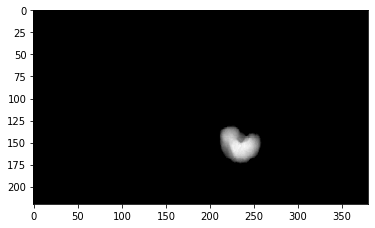

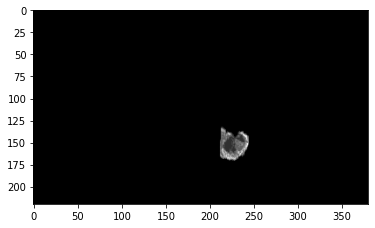

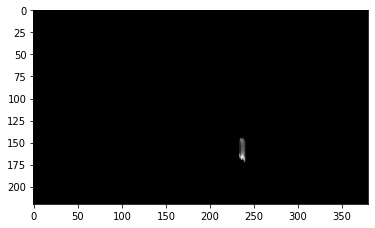

In [208]:
plt.imshow(np.mean(leftKidneyMask,axis=0),cmap='gray')
plt.show()
plt.imshow(np.mean(cortexMask,axis=0),cmap='gray')
plt.show()
plt.imshow(np.mean(doctorsMask,axis=0),cmap='gray')
plt.show()

In [209]:
dice=2*np.sum(doctorsMask*cortexMask)/(np.sum(doctorsMask)+np.sum(cortexMask))
print(dice)
print(np.sum(doctorsMask*cortexMask)/np.sum(doctorsMask))

0.040398874968038866
0.09881175734834272


In [210]:
print(findBoundingBox(cortexMask))
print(findBoundingBox(doctorsMask))
k1,k2,k3,k4,k5,k6=findBoundingBox(doctorsMask)

(119, 158, 132, 171, 212, 245)
(119, 158, 144, 173, 234, 241)


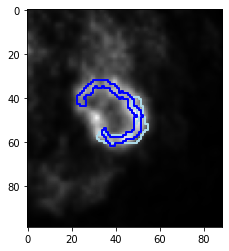

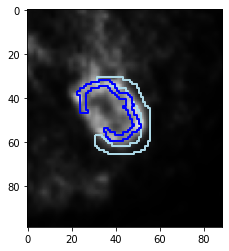

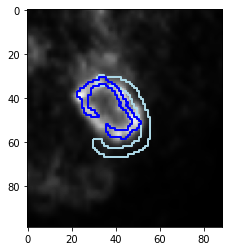

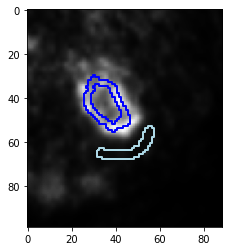

In [214]:
for i in [234,236,238,240]:
    plt.imshow(img4d[(k1-30):(k2+30),(k3-30):(k4+30),i,10],cmap='gray')
    plot_outlines(doctorsMask[(k1-30):(k2+30),(k3-30):(k4+30),i].T, lw=2, color='lightblue')
    plot_outlines(cortexMask[(k1-30):(k2+30),(k3-30):(k4+30),i].T, lw=2, color='blue')
    fig=plt.gcf()
    fig.savefig('sli{}.png'.format(i),bbox_inches='tight')
    plt.show()

In [59]:
cortexTAC=findOrganTAC(img4d,cortexMask)
print(cortexTAC)
doctorsTAC=findOrganTAC(img4d,doctorsMask)
print(doctorsTAC)
tsTAC=findOrganTAC(img4d,leftKidneyMask)
print(tsTAC)

[3.98613913e+01 6.51044993e+01 1.60839889e+02 1.44765794e+03
 1.91799100e+04 4.15749659e+04 5.60276627e+04 6.19457152e+04
 6.56384094e+04 5.31911430e+04 5.39603380e+04 4.85713777e+04
 4.23727414e+04 2.80782594e+04 3.20596549e+04 2.70443019e+04
 2.22666741e+04 1.98903763e+04 1.75510571e+04 1.66964727e+04
 1.59998312e+04 1.53394567e+04 1.52669312e+04 1.39007866e+04]
[   55.8063705     32.11786456    95.86718148   756.37146767
  6218.89773575 16030.00006673 22778.48731113 27100.02650714
 23270.76785864 26963.64847113 22600.23305955 17386.00821536
 18351.90518078 16451.36733898 14271.9608381  11774.93201231
 11554.46971792  9575.14284094  9396.35428487  8618.83777609
  8301.20289566  7910.85050039  7854.08650633  7676.86526328]
[3.25298216e+01 6.08554319e+01 1.50975628e+02 1.25845555e+03
 1.03723393e+04 2.16448130e+04 2.97009263e+04 3.39903508e+04
 3.35396170e+04 3.52948632e+04 3.00961096e+04 2.58028616e+04
 2.51727076e+04 2.55556591e+04 2.04127046e+04 1.78003943e+04
 1.66222399e+04 1.4543

In [60]:
print((cortexTAC-doctorsTAC)/doctorsTAC)
print((tsTAC-doctorsTAC)/doctorsTAC)

[-0.2857197   1.02704944  0.6777367   0.91395101  2.08413337  1.59357241
  1.45967443  1.28581751  1.82063788  0.97269828  1.38760095  1.79370498
  1.3089015   0.7067432   1.24633849  1.29676926  0.9271048   1.07729291
  0.86785817  0.93720698  0.92741118  0.93904015  0.94382009  0.81073734]
[-0.41709483  0.89475336  0.57484162  0.66380622  0.66787424  0.35026905
  0.30390249  0.25425526  0.44127677  0.3089795   0.33167253  0.4841165
  0.37166726  0.55340639  0.4302663   0.5117195   0.43859825  0.51889897
  0.43725326  0.47555824  0.45732179  0.49570001  0.52189963  0.52353257]


In [91]:
leftKidneyMask=np.array(img==38,dtype=int)
leftKidneyMask=greatestConnectedComponentOnly(leftKidneyMask)
k1,k2,k3,k4,k5,k6=findBoundingBox(leftKidneyMask)

In [92]:
ctfilepath='D:/koveri/Data/koveri0001/CT_3.0__Br36__5'
ctImg=readDcmCt(ctfilepath)

In [93]:
k5=k5-5
img1=greatestConnectedComponentOnly(np.array(img==38,dtype=int))
tsArr1=img1[k1:k2,k3:k4,k5:k6]

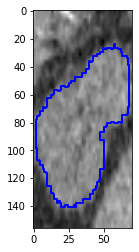

In [171]:
ctArr=ctImg[k1:k2,k3:k4,k5:k6]
i=23
kuv=ctArr[i,:,:]
kuv=cv2.resize(kuv,(round(3*tsArr1.shape[2]),round(1.65*tsArr1.shape[1])))
kuv=cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE)
plt.imshow(kuv,cmap='gray')
kuv=np.array(tsArr1[i,:,:],dtype='uint8')
kuv=cv2.resize(kuv,(round(3*tsArr1.shape[2]),round(1.65*tsArr1.shape[1])))
kuv=cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE)
plot_outlines(kuv.T, lw=2, color='blue')
fig=plt.gcf()
#fig.savefig('kfig1.png',bbox_inches='tight')

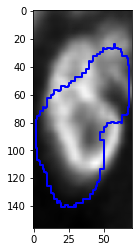

In [172]:
imgArr=img4d[k1:k2,k3:k4,k5:k6,:]
imgArr1=np.mean(imgArr,axis=3)
kuv=imgArr1[i,:,:]
kuv=cv2.resize(kuv,(round(3*tsArr1.shape[2]),round(1.65*tsArr1.shape[1])))
kuv=cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE)
plt.imshow(kuv,cmap='gray')
kuv=np.array(tsArr1[i,:,:],dtype='uint8')
kuv=cv2.resize(kuv,(round(3*tsArr1.shape[2]),round(1.65*tsArr1.shape[1])))
kuv=cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE)
plot_outlines(kuv.T, lw=2, color='blue')
fig=plt.gcf()
#fig.savefig('kfig2.png',bbox_inches='tight')

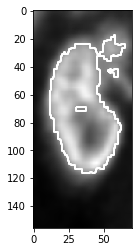

In [173]:
imgArr=img4d[k1:k2,k3:k4,k5:k6,:]
imgArr1=np.mean(imgArr,axis=3)
kuv=imgArr1[i,:,:]
kuv=cv2.resize(kuv,(round(3*tsArr1.shape[2]),round(1.65*tsArr1.shape[1])))
kuv=cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE)
plt.imshow(kuv,cmap='gray')
arr=findIniArr(img4d,k1,k2,k3,k4,k5,k6)
kuv=np.array(arr[i,:,:],dtype='uint8')
kuv=cv2.resize(kuv,(round(3*tsArr1.shape[2]),round(1.65*tsArr1.shape[1])))
kuv=cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE)
plot_outlines(kuv.T, lw=2, color='white')
fig=plt.gcf()
#fig.savefig('kfig3.png',bbox_inches='tight')

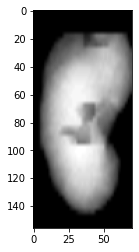

In [174]:
arr[:,:,5:52]=arr[:,:,0:47]
arr[:,:,0:5]=0
kuv=np.mean(arr[:,:,0:47],axis=0)#np.pad(, [(0,0), (5,0)], 'constant')
kuv=cv2.resize(kuv,(round(3*tsArr1.shape[2]),round(1.65*tsArr1.shape[1])))
kuv=cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE)
plt.imshow(kuv,cmap='gray')

In [99]:
com=np.array(ndimage.measurements.center_of_mass(arr))
l0,l1,theta,phi=findTheAxis(arr,com)
mu,d=findTheNonConvexDirection(arr,com,l0,l1,theta,phi)
x,y=findAuxiliaryPoints(arr,com,l0,l1,theta,phi,mu)

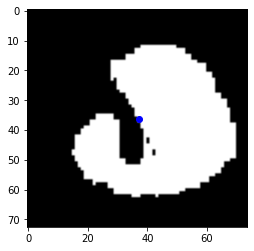

In [100]:
h=np.max(arr.shape*np.array((1.65,1.65,3)))/3
kul=5/4*math.pi-phi
theta1=math.pi/2-theta+abs(kul-math.pi)/math.pi*2*theta
phi1=phi+kul
s1=com+pointFromPolarCoordinates(h,theta1,phi1)
kul=7/4*math.pi-phi
theta1=math.pi/2-theta+abs(kul-math.pi)/math.pi*2*theta
phi1=phi+kul
s2=com+pointFromPolarCoordinates(h,theta1,phi1)
kul=3/4*math.pi-phi
theta1=math.pi/2-theta+abs(kul-math.pi)/math.pi*2*theta
phi1=phi+kul
s3=com+pointFromPolarCoordinates(h,theta1,phi1)
projectedCom=findProjectedPoint(com,s1,s2,s3)
img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
plt.imshow(img1,cmap='gray')
plt.plot(projectedCom[1],projectedCom[0],'ob')
fig=plt.gcf()
#fig.savefig('kfig4.png',bbox_inches='tight')

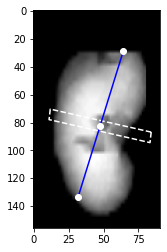

In [101]:
s4=s2+(s3-s1)
kuv=np.mean(arr,axis=0)
kuv=cv2.resize(kuv,(round(3*arr.shape[2]),round(1.65*arr.shape[1])))
kuv=np.pad(cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE), [(0,0), (10,10)], 'constant')
plt.plot([71-1.65*s1[1]+10,71-1.65*s2[1]+10,71-1.65*s4[1]+10,71-1.65*s3[1]+10,71-1.65*s1[1]+10],
         [3*s1[2],3*s2[2],3*s4[2],3*s3[2],3*s1[2]],'w--')
plt.plot([71-1.65*l0[1]+10,71-1.65*l1[1]+10],[3*l0[2],3*l1[2]],'-',color='blue')
plt.plot(71-1.65*l0[1]+10,3*l0[2],'ow')
plt.plot(71-1.65*l1[1]+10,3*l1[2],'ow')
plt.plot(71-1.65*com[1]+10,3*com[2],'ow')
plt.imshow(kuv,cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig5.png',bbox_inches='tight')

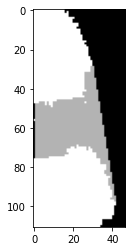

In [102]:
s1=l0+0.3*(d-com)
s2=l0
s3=l1+(s1-l0)
img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
vertices=getTheVertices(img1)
if len(vertices)>0:
    vertices=np.array(vertices)
    hull=ConvexHull(np.array(vertices))
    poly=Polygon(vertices[hull.vertices,:][:,[1,0]])
    hullImg=rasterize([poly],out_shape=(img1.shape))
    nonConvexImg=np.maximum(hullImg-img1,np.zeros((img1.shape)))
    nonConvexImg=greatestConnectedComponentOnly(nonConvexImg)
    kuv=img1+0.7*nonConvexImg
    kuv=cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE)
    plt.imshow(kuv,cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig6.png',bbox_inches='tight')

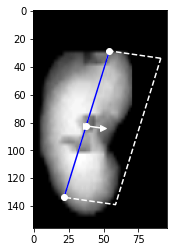

In [103]:
s4=s2+(s3-s1)
kuv=np.mean(arr,axis=0)
kuv=cv2.resize(kuv,(round(3*arr.shape[2]),round(1.65*arr.shape[1])))
kuv=np.pad(cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE), [(0,0), (0,25)], 'constant')
plt.plot([71-1.65*s1[1],71-1.65*s2[1],71-1.65*s4[1],71-1.65*s3[1],71-1.65*s1[1]],
         [3*s1[2],3*s2[2],3*s4[2],3*s3[2],3*s1[2]],'w--')
plt.plot([71-1.65*l0[1],71-1.65*l1[1]],[3*l0[2],3*l1[2]],'-',color='blue')
plt.plot(71-1.65*l0[1],3*l0[2],'ow')
plt.plot(71-1.65*l1[1],3*l1[2],'ow')
plt.plot(71-1.65*com[1],3*com[2],'ow')
dirPoint=com+0.1*(d-com)
plt.plot([71-1.65*com[1],71-1.65*dirPoint[1]],[3*com[2],3*dirPoint[2]],'->',color='white')
plt.imshow(kuv,cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig7.png',bbox_inches='tight')

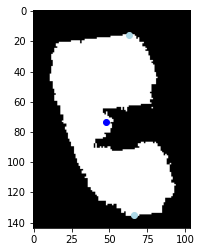

In [104]:
com=np.array(ndimage.measurements.center_of_mass(arr))
h=np.max(arr.shape*np.array((1.65,1.65,3)))
theta1=math.pi/2-theta+abs(math.pi-mu)/math.pi*2*theta
phi1=phi+mu
point=com+pointFromPolarCoordinates(h/3,theta1,phi1)
s1=point+1.3*(l0-com)
s2=com+1*(com-point)+1.3*(l0-com)
s3=point+1.3*(l1-com)
img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
projectedCom=findProjectedPoint(com,s1,s2,s3)
projectedx=findProjectedPoint(x,s1,s2,s3)
projectedy=findProjectedPoint(y,s1,s2,s3)
kuv=img1
kuv=cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE)
plt.imshow(kuv,cmap='gray')
plt.plot(100-projectedCom[0],projectedCom[1],'ob')
plt.plot(100-projectedx[0],projectedx[1],'o',color='lightblue')
plt.plot(100-projectedy[0],projectedy[1],'o',color='lightblue')
fig=plt.gcf()
#fig.savefig('kfig8.png',bbox_inches='tight')
plt.show()

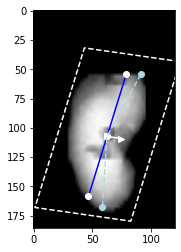

In [105]:
s4=s2+(s3-s1)
kuv=np.mean(arr,axis=0)
kuv=cv2.resize(kuv,(round(3*arr.shape[2]),round(1.65*arr.shape[1])))
kuv=np.pad(cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE), [(25,5), (25,25)], 'constant')
plt.plot([71-1.65*s1[1]+25,71-1.65*s2[1]+25,71-1.65*s4[1]+25,71-1.65*s3[1]+25,71-1.65*s1[1]+25],
         [3*s1[2]+25,3*s2[2]+25,3*s4[2]+25,3*s3[2]+25,3*s1[2]+25],'w--')
plt.plot([71-1.65*l0[1]+25,71-1.65*l1[1]+25],[3*l0[2]+25,3*l1[2]+25],'-',color='blue')
plt.plot(71-1.65*l0[1]+25,3*l0[2]+25,'ow')
plt.plot(71-1.65*l1[1]+25,3*l1[2]+25,'ow')
plt.plot(71-1.65*com[1]+25,3*com[2]+25,'ow')
plt.plot([71-1.65*com[1]+25,71-1.65*dirPoint[1]+25],[3*com[2]+25,3*dirPoint[2]+25],'->',color='white')
plt.plot(71-1.65*x[1]+25,3*x[2]+25,'o',color='lightblue')
plt.plot(71-1.65*y[1]+25,3*y[2]+25,'o',color='lightblue')
plt.plot([71-1.65*x[1]+25,71-1.65*com[1]+25,71-1.65*y[1]+25],[3*x[2]+25,3*com[2]+25,3*y[2]+25],'--',color='lightblue')
plt.imshow(kuv,cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig9.png',bbox_inches='tight')

In [106]:
circleCenters=[]
com=np.array(ndimage.measurements.center_of_mass(arr))
h=np.max(arr.shape*np.array((1.65,1.65,3)))
n=round(100*distanceBetweenTwoPoints(x,com)/(distanceBetweenTwoPoints(x,com)+distanceBetweenTwoPoints(com,y)))
for i in range(100):
    if i<n:
        point=x+i/n*(com-x)
    else:
        point=com+(i-n)/(100-n)*(y-com)
    circleCenters.append(point)

circlePoints1=[]
i=75
if i<n:
    point=x+i/n*(com-x)
else:
    point=com+(i-n)/(100-n)*(y-com)
s1=point+pointFromPolarCoordinates(h,math.pi/2,phi+math.pi/2)
s2=point+pointFromPolarCoordinates(h,math.pi/2-theta,phi+math.pi)
s3=point+pointFromPolarCoordinates(h,math.pi/2+theta,phi)
img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
vertices=getTheVertices(img1)
vertices=np.array(vertices)
r=round(np.max((vertices[:,0]-img1.shape[0]/2)**2+(vertices[:,1]-img1.shape[1]/2)**2)**0.5)
for j in range(100):
    kul=j/100*2*math.pi
    linesegment=np.zeros((r))
    s=r
    t=np.array(img1.shape)/2+s*np.array((math.cos(kul),math.sin(kul)))
    tIn3d=findPointIn3d(t,s1,s2,s3)
    circlePoints1.append(tIn3d)

circlePoints2=[]
com=np.array(ndimage.measurements.center_of_mass(arr))
h=np.max(arr.shape*np.array((1.65,1.65,3)))
n=round(100*distanceBetweenTwoPoints(x,com)/(distanceBetweenTwoPoints(x,com)+distanceBetweenTwoPoints(com,y)))
i=50
if i<n:
    point=x+i/n*(com-x)
else:
    point=com+(i-n)/(100-n)*(y-com)
s1=point+pointFromPolarCoordinates(h,math.pi/2,phi+math.pi/2)
s2=point+pointFromPolarCoordinates(h,math.pi/2-theta,phi+math.pi)
s3=point+pointFromPolarCoordinates(h,math.pi/2+theta,phi)
img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
vertices=getTheVertices(img1)
vertices=np.array(vertices)
r=round(np.max((vertices[:,0]-img1.shape[0]/2)**2+(vertices[:,1]-img1.shape[1]/2)**2)**0.5)
for j in range(100):
    kul=j/100*2*math.pi
    linesegment=np.zeros((r))
    s=r
    t=np.array(img1.shape)/2+s*np.array((math.cos(kul),math.sin(kul)))
    tIn3d=findPointIn3d(t,s1,s2,s3)
    circlePoints2.append(tIn3d)

circlePoints3=[]
com=np.array(ndimage.measurements.center_of_mass(arr))
h=np.max(arr.shape*np.array((1.65,1.65,3)))
n=round(100*distanceBetweenTwoPoints(x,com)/(distanceBetweenTwoPoints(x,com)+distanceBetweenTwoPoints(com,y)))
i=15
if i<n:
    point=x+i/n*(com-x)
else:
    point=com+(i-n)/(100-n)*(y-com)
s1=point+pointFromPolarCoordinates(h,math.pi/2,phi+math.pi/2)
s2=point+pointFromPolarCoordinates(h,math.pi/2-theta,phi+math.pi)
s3=point+pointFromPolarCoordinates(h,math.pi/2+theta,phi)
img1=imageFromThreeCoordinates(s1,s2,s3,arr,method='round')
vertices=getTheVertices(img1)
vertices=np.array(vertices)
r=round(np.max((vertices[:,0]-img1.shape[0]/2)**2+(vertices[:,1]-img1.shape[1]/2)**2)**0.5)
for j in range(100):
    kul=j/100*2*math.pi
    linesegment=np.zeros((r))
    s=r
    t=np.array(img1.shape)/2+s*np.array((math.cos(kul),math.sin(kul)))
    tIn3d=findPointIn3d(t,s1,s2,s3)
    circlePoints3.append(tIn3d)

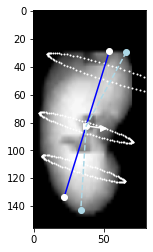

In [107]:
s4=s2+(s3-s1)
kuv=np.mean(arr,axis=0)
kuv=cv2.resize(kuv,(round(3*arr.shape[2]),round(1.65*arr.shape[1])))
kuv=np.pad(cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE), [(0,0), (0,10)], 'constant')
#for i in circleCenters:
#    plt.plot(71-1.65*i[1],3*i[2],'o',color='lightblue',markersize=1)
for i in circlePoints1:
    plt.plot(71-1.65*i[1],3*i[2],'ow',markersize=1)
for i in circlePoints2:
    plt.plot(71-1.65*i[1],3*i[2],'ow',markersize=1)
for i in circlePoints3:
    plt.plot(71-1.65*i[1],3*i[2],'ow',markersize=1)
plt.plot([71-1.65*l0[1],71-1.65*l1[1]],[3*l0[2],3*l1[2]],'-',color='blue')
plt.plot(71-1.65*l0[1],3*l0[2],'ow')
plt.plot(71-1.65*l1[1],3*l1[2],'ow')
plt.plot(71-1.65*com[1],3*com[2],'ow')
plt.plot([71-1.65*com[1],71-1.65*dirPoint[1]],[3*com[2],3*dirPoint[2]],'->',color='white')
plt.plot(71-1.65*x[1],3*x[2],'o',color='lightblue')
plt.plot(71-1.65*y[1],3*y[2],'o',color='lightblue')
plt.plot([71-1.65*x[1],71-1.65*com[1],71-1.65*y[1]],[3*x[2],3*com[2],3*y[2]],'--',color='lightblue')
plt.imshow(kuv,cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig10.png',bbox_inches='tight')

In [158]:
iniArr=findInitialCortexArray(x,y,theta,phi,arr,com,img4d,k1,k2,k3,k4,k5,k6)

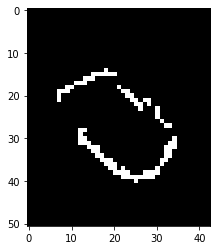

In [159]:
plt.imshow(iniArr[:,:,30],cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig14.png',bbox_inches='tight')

In [160]:
iniArr=connectCortexPoints(iniArr,l0,l1)

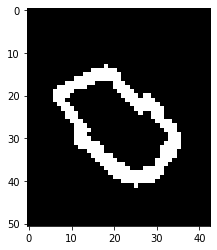

In [161]:
plt.imshow(iniArr[:,:,30],cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig15.png',bbox_inches='tight')

In [194]:
medullaArr,cortexArr=divideMedullaAndCortex(iniArr,l0,l1)

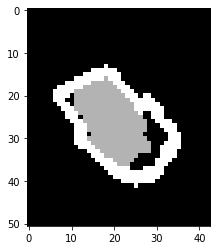

In [195]:
kuv=cortexArr[:,:,30]+0.7*medullaArr[:,:,30]
plt.imshow(kuv,cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig16.png',bbox_inches='tight')

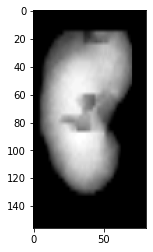

In [176]:
kuv=np.mean(arr,axis=0)
kuv=cv2.resize(kuv,(round(3*arr.shape[2]),round(1.65*arr.shape[1])))
kuv=np.pad(cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE), [(0,0), (0,10)], 'constant')
plt.imshow(kuv,cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig17.png',bbox_inches='tight')

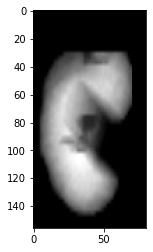

In [169]:
arr1=removeVesselArea(arr,com,d,x,y)
kuv=np.mean(arr1,axis=0)
kuv=cv2.resize(kuv,(round(3*arr.shape[2]),round(1.65*arr.shape[1])))
kuv=np.pad(cv2.rotate(kuv,cv2.cv2.ROTATE_90_CLOCKWISE), [(0,0), (0,10)], 'constant')
plt.imshow(kuv,cmap='gray')
fig=plt.gcf()
#fig.savefig('kfig18.png',bbox_inches='tight')

In [196]:
medullaArr=removeVesselArea(medullaArr,com,d,x,y)
cortexArr=removeVesselArea(cortexArr,com,d,x,y)

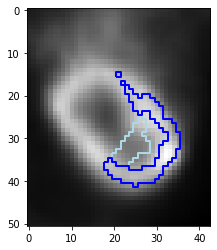

In [206]:
i=30#20,25,30
imgArr=img4d[k1:k2,k3:k4,k5:k6,:]
imgArr1=np.mean(imgArr,axis=3)
plt.imshow(imgArr1[:,:,i],cmap='gray')
plot_outlines(medullaArr[:,:,i].T, lw=2, color='lightblue')
plot_outlines(cortexArr[:,:,i].T, lw=2, color='blue')
fig=plt.gcf()
fig.savefig('kfig21.png',bbox_inches='tight')
plt.show()